In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import dgl
import networkx as nx
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import networkx as nx
import yfinance as yf
import time

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import PPI

from torch_geometric.loader import DataLoader
import torch_geometric
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn

from sklearn import preprocessing
import random

class bcol:
    
    b = '\033[1m'
    end = '\033[0m'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [30]:
tickers = pd.read_csv('/Users/difen/Documents/advanced_seminar/tickers_3_5k.csv', on_bad_lines='skip', sep=';')
tickers_lst = list(tickers.sort_values('Symbol')['Symbol'][:20])

df = yf.download(tickers_lst, auto_adjust=True, start='2021-01-01', end='2023-01-01', interval='1mo')['Close'].dropna(axis=1)

[*********************100%***********************]  20 of 20 completed


In [31]:
#encoding labels

final_tickers = df.columns
sectors_dct = {}
for ticker in final_tickers:
    try:
        sectors_dct[ticker] = yf.Ticker(ticker).info['sector']
    except:
        continue
sectors = np.array(list(sectors_dct.values()))
le = preprocessing.LabelEncoder()
le.fit(sectors)
encoded_sectors = torch.tensor(le.transform(sectors), dtype=torch.long)
num_classes = encoded_sectors.unique().shape[0]
print(num_classes, encoded_sectors)

8 tensor([4, 0, 5, 5, 5, 1, 7, 6, 5, 3, 5, 4, 4, 3, 4, 4, 2, 1, 5])


In [33]:
def adj_matrix(df, y_col):
    adj_matrix = []
    df['ind'] = np.linspace(start=0, stop=df.shape[0]-1, num=df.shape[0])
    for i in range(df.shape[0]): 
        node_edges = []
        current_node_val = df.iloc[i][y_col]
        for j in range(df.shape[0]):
            if (i == j) | (i == j+1) | (i == j-1):
                node_edges.append(1)
                continue
            second_node_val = df.iloc[j][y_col] 
            nodes_between = df[((df['ind'] > i) & (df['ind'] < j)) |
                                ((df['ind'] < i) & (df['ind'] > j))].copy()

            nodes_between['y_between'] = nodes_between['ind'].map(lambda ind_c: second_node_val + (current_node_val - second_node_val) * (abs(j - ind_c)/ abs(j - i)))
            nodes_between['check_visibility'] = nodes_between[[y_col, 'y_between']].apply(lambda x: 0 if x[0] < x[1] else 1, axis=1)
            if nodes_between['check_visibility'].sum() > 0:
                node_edges.append(0)
            else: 
                node_edges.append(1)
        adj_matrix.append(node_edges)
    
    return torch.tensor(adj_matrix) - torch.eye(df.shape[0])

def build_edge_list(edges, ts, y_col=None): # build edge list from adj matrix / ts
    if ts:
        edges = adj_matrix(edges, y_col)
    edge_list = []
    for i in range(0, edges.shape[0]):
        for j in range(edges.shape[0]):
            if (edges[i,j] == 1) & (i != j):
                edge_list.append((i, j))
    return torch.tensor(edge_list, dtype=torch.long).transpose(0, 1)
    #return edge_list

In [38]:
edge_lists = [build_edge_list(df.loc[:,[ticker]], ts=True, y_col=ticker) for ticker in df.columns]
zip_data = list(zip(torch.tensor(df.values.transpose(), dtype=torch.float), edge_lists, encoded_sectors)) #ts values | edge_list | label

In [39]:
#making a graph 
graphs_lst = []
for i in range(df.shape[1]):
    x = zip_data[i][0].reshape(-1, 1)
    edge_index = zip_data[i][1]
    y = zip_data[i][2]

    graph = Data(x=x, edge_index=edge_index, y=y)
    graphs_lst.append(graph)

77
AAON


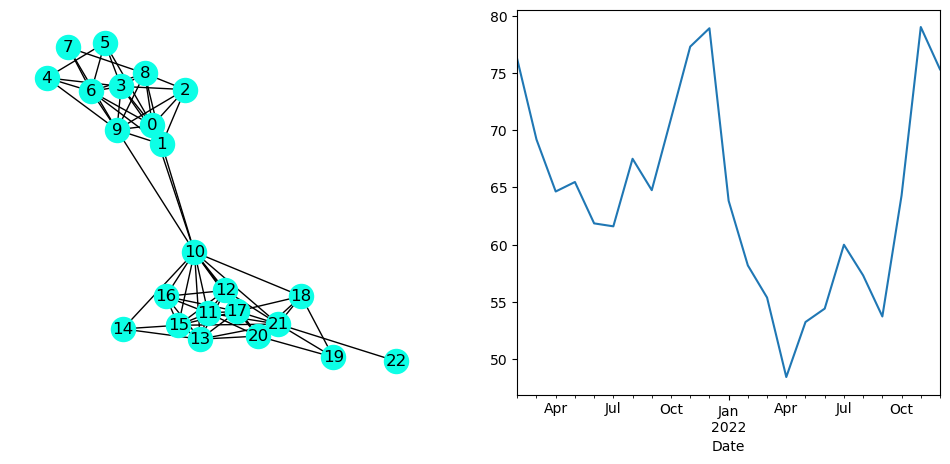

In [74]:
i = 4
print(int(graphs_lst[i].edge_index.shape[1] / 2))
print(df.columns[i])

g = torch_geometric.utils.to_networkx(graphs_lst[i], to_undirected=True)
plt.subplot(121)
nx.draw(g, with_labels=True, node_color=[[.05, 1, .9]])

plt.subplot(122)
df.iloc[:,i].plot(figsize=(12,5));

In [11]:
#dataset in batches
shuffle(graphs_lst)
loader = DataLoader(graphs_lst[:550], batch_size=256, shuffle=False)
test_loader = DataLoader(graphs_lst[550:], batch_size=32, shuffle=False)
list(loader)

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim) 
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = pyg_nn.global_mean_pool(x, batch)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


criterion = nn.CrossEntropyLoss()
net = MyModel(1, 256, 5)
optimizer = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(300):
    total_train_loss = 0
    net.train()
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        out = net(data.x, data.edge_index, data.batch)
        
        loss = criterion(out, data.y)
        loss.backward()
        total_train_loss += loss.item()
    
        optimizer.step()

    if (epoch + 1) % 10 == 0: 
        with torch.no_grad():
            net.eval()
            n_correctly_predicted = 0
            n_graphs = 0
            for data in test_loader:
                out = net(data.x, data.edge_index, data.batch)
                _, predicted_class = torch.max(out, 1)
                n_correctly_predicted += predicted_class.eq(data.y).sum()
                n_graphs += data.y.shape[0]
    
    print(f'epoch: {epoch + 1} total_train_loss: {np.round(total_train_loss, 3)}, accuracy: {np.round(n_correctly_predicted.item() / n_graphs, 3)}%')